---
# 4. Simulation
---

In my simulation study I want to analyze how the variance of the PCR coefficients differ if the true VCV matrix is not known by applying the model introduced in section three. Since the covariances of some model variables are not really trackable and to have a realistic set-up, I decided to simulate a true population from which I will subsequently draw different samples for my analysis to examine the behavior of the parameter variance. 

## 4.1 Parameterization of the Model

To ease the readability I decided to create a table that includes the full name, mathematical abbreviation of section three, the chosen parameterization and a short reasoning why I chose this specific value. 

**Table X.X - Parameterization**

|Dependency| Name | Abbreviation   | Value | Reasoning | Source
|------|------|------|------|------|------|
|Ability||||||
||Variance of Ability | $\sigma^2_a$ | 1 | Since ability is not measurable and an artificial variable and an increase of the variance has the same effect as increasing $|\gamma_{ability}|$. Hence, I decided to choose the standard normal distribution for my parametrization.| -|
|Age||||||
||Maximum Age | - | 68 | I chose the state pension age as maximum age of the individuals because.| British Government [(2018)](https://www.gov.uk/state-pension-age))|
||Minimum Age | - | 33 | I chose the age that is used for the full population in Blundell et al (2005). This has the advantage that all individuals have finished school.| Blundell et al. (2005)|
|General|||||
|| Population Size | N | 460,000 | In 1991 there were 22,997,199 people in the UK. To reduce computational costs, I decided to set the whole population to around 2\% of UK's true population in 1991. This still allows me in the simulaton study to draw large samples without having the problem that the samples are very likely to be substantially equal.| [Office for National Statistics](https://www.ons.gov.uk/file?uri=/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/populationestimatesforukenglandandwalesscotlandandnorthernireland/mid2015/ukandregionalpopulationestimates18382015.zip)|
|Number of Siblings||||||
||Decrease in Expected Value of Number of Siblings for each Unit of Parent's Education| $p$ | 0.1 |  In Cygan-Rehm and Maeder (2013) they report this value to be 0.1. The model that is used in the paper is a linear model. However, the quantity has the same interpretation and thus I use the same number. | Cygan-Rehm and Maeder (2013)|
||Mean/Variance of Number of Siblings | $(\mu_n, \sigma_n^2)$ | (1.692, 2.89)  | From the summary Statistics of Blundell et al. (2005) | Blundell et al. (2005) |
|Parent's Education||||||
|| Mean/Variance of Years Education of Parent's | $(\mu_e, \sigma_e^2)$ | (13.342, 21.215)  | In the summary Statistics of Blundell et al. (2005) the mean/standard deviation of father's and mother's education are given. Both are given as the years of education after 6th grade. Hence I did my calculations using the value reported in the paper plus six. Moreover, this transformation does not affect the variance. This is in line with the value reported by the Human Development Report for the United Kingdom in 1991.  Since the moments do not meaningfully differ for fathers and mothers, I decided to only use the mother's education.  | Blundell et al. (2005), [Human Development Report](http://hdr.undp.org/en/indicators/103006) | 
|Test Scores||||||
||Influence of Ability and Parent's Education on the Latent Test Scores| $(\gamma_{ability},\gamma_{parent})$ | (2,2) | I chose $\gamma_{ability}$ and $\gamma_{parent}$ to be equal. The magnitude turned out to yield reasonable results. | - |
||Proportion of Individuals that Scored a (5, 4, 3, 2, 1) in 7th Grade Math | $Gr_{7,m}$ | (0.141, 0.158, 0.185, 0.190, 0.212)| I chose to use the reported quintiles for each test as approximation of the probability mass.| Blundell et al. (2005)|
||Proportion of Individuals that Scored a (5, 4, 3, 2, 1) in 11th Grade Math | $Gr_{11,m}$ | (0.122,0.152, 0.157, 0.179, 0.199)| I chose to use the reported quintiles for each test as approximation of the probability mass.| Blundell et al. (2005)|
||Proportion of Individuals that Scored a (5, 4, 3, 2, 1) in 7th Grade Reading | $Gr_{7,r}$ | (0.166, 0.179, 0.188, 0.187, 0.165)| I chose to use the reported quintiles for each test as approximation of the probability mass.| Blundell et al. (2005)|
||Proportion of Individuals that Scored a (5, 4, 3, 2, 1) in 11th Grade Reading | $Gr_{11,r}$ | (0.132, 0.163, 0.163, 0.176, 0.176)| I chose to use the reported quintiles for each test as approximation of the probability mass.| Blundell et al. (2005)|
|| Variance of Normally Distributed Errors for Test Scores at grade 7| $\sigma_7^2$| 1 | Higher variance of the error decreases the correlation of ability and parent's education with the test outcomes. This parameter must be seen relatively to $\gamma_{ability}$ and $\gamma_{parent}$. Hence, I chose standard normal distributed errors to allow for high correlation between the variables without being forced to use very high values of $\gamma_{ability}$ and $\gamma_{parent}$.| - | 
|| Variance of Normally Distributed Errors for Test Scores at grade 11| $\sigma_{11}^2$| 30 | Higher variance of the error decreases the correlation of tests in 7th and 11th grade. It turned out, that given the other parameter choices, a high value of 30 induces a correlation of around 0.9 between the tests, which I regard as desirable.| - | 
|Wages||||||
||Lower Bounds for the Betas in the Wage Regression (schooling, working, working_sqr/100, number of Siblings, parent's education)| $\beta^{min}$ | (0.03, 0.01, -0.06, -10, 0.01) | The values for schooling, work experience and the squared work experience are chosen such that they are close to the values in Björklund and Kjellström (2002). For the number of Siblings I wanted to set a non-binding bound. To allow changes in this, I found it reasonable to also incorporate the constraint in the code and set it to a very high value. Parent's education should have a positive influence on the wages, hence I chose a small positive number. | Björklund and Kjellström (2002) |
||Mean/Variance of Logarithmic Wage| $(\mu_Y, \sigma^2_Y)$ | (2.040, 1.5) |  Blundell et al. (2005) | Blundell et al. (2005) |
||Upper Bounds for the Betas in the Wage Regression (constant, schooling, working, working_sqr/100, number of Siblings, parent's education) | $\beta^{max}$ | (0.06, 0.06, -0.03, 10, 10) | The values for schooling, work experience and the squared work experience are chosen such that they are close to the values in Björklund and Kjellström (2002). For the number of Siblings and parent's education I wanted to set a non-binding upper bound and thus choose a high value for the coefficients. To allow changes in the latter two quantities, I found it reasonable to also incorporate the constraint in the code.  | Björklund and Kjellström (2002) |
||Weighting of Squarred Deviation to Expected Value and Standard Deviation for the Logarithmic Wage | $\tau$ | 0.5 | I choose equal weights for the Expected Value and the Standard Deviation. A change in $\tau$ did only change the sresults in a very small magnitude.| - |
|Years of Schooling||||||
||Maximum Years of Schooling| m | 29 | I decided to allow that an individual did education since it entered school at 4 until the age 33. | - |
||Mean/Variance of Years of Schooling | $(\mu_s, \sigma_s^2)$ | (13.342, 21.215)  | In the summary Statistics of Blundell et al. (2005) the mean/standard deviation of the years of schooling of an individual are not given. Hence, I decided to use the same moments as for parent's education.  | Blundell et al. (2005)| 
||Minimum Years of Schooling| - | 0 | I decided to use zero. This comes with the cost that some individuals have unrealistic few years of schooling. However, this helps to stay more in line with the given moments. Setting this to a higher value and modify the structure of the years of schooling is a desirable addition for further analysis. | - |
||Persistence of Parent's Education on Children's Education | $q$ | 0.85 | Using the given moments of parent's education and schooling, the coefficient that sets the lower bound for $q$ in equation *3.13* is equal to $\frac{21.215 - 13.342^2/3}{13.342 - 13.342^2/3} \approx 0.8288$. Hence, I decided to use 0.85. The choice of the coefficient does not change the results qualitatively. | -|
|Years of Working experience||||||
||Age at School Enrollment | $age\_schoolenrollment$ | 4 | The enrollment age for school of most children is four in Great Britain. |  [British Government](https://www.gov.uk/schools-admissions/school-starting-age)|
||Probability Mass of Gap Years (0,1,2,3,4) | $F_{gap}$ |  (0.59, 0.11,0.7,0.04, 0.03) | Unfortunately I could not find data for the UK. Holmlund et al. (2008) report swedish data for gap years between schooling and university in 1991. I use this data and assume that everyone that does not go to university does not take gap any gap year.  | Holmlund et al. (2008) |

## 4.2 Description of the whole Population



First I simulate the whole population with the parameterizations presented in section *4.1*. I have wrapped the whole data generating process in a function. The whole function can be found in the Github repository's folder ['R'](https://github.com/manuhuth/PCR-Parameter-Variance-Analysis/tree/master/R) in the file *DGP_function*. Since the data set is very large I decided to simulate it in advance and upload the data to Github. The code I used to simulate is given in the next cell. I have listed the inputs in the same order as they appear in Table X.X. The function additionally allows to tune the optimization to obtain the logarithmic wage. 

In [98]:
#At the end set this on top of the notebook
options(repr.plot.width=8, repr.plot.height=4) #adjust plots

setwd('C:/Users/Mhuth/Desktop/PCRPVA')
files <- c('PCA_PropVar', 'PCA', 'PCR_cv', 'PCR_predict', 'PCR', 'random_discreteVariables', 'random_VCV', 'DGP_function', 'plot_functions', 'coef_var_analysis') #names of files to read
for (i in 1:length(files)) { #loop to read all files
  source(paste('R/', files[i], '.R', sep = ''))
}

library(readxl)
library(gridExtra)
library(ggplot2) #whole cell later at the beginning

In [24]:
set.seed(123)
N <- 2300000
#population <- dgp_model(var_ability = 1, max_age = 68, min_age = 33, n = N, prob_numbSiblings = 0.1, mean_numberSiblings = 1.692, var_numberSiblings = 2.89,
#                      mean_parent_educ = 13.342, variance_parent_educ = 21.215,
#                      gamma_ability = 2,  gamma_parent_educ = 2,
#                      breaks_test7_m = c(0, 0.141, 0.158, 0.185, 0.190, 0.212),  breaks_test11_m = c(0, 0.122,0.152, 0.157, 0.179, 0.199),
#                      breaks_test7_r =  c(0, 0.166, 0.179, 0.188, 0.187, 0.165),  breaks_test11_r = c(0, 0.132, 0.163, 0.163, 0.176, 0.176), test_cat = TRUE, var_err = 1,
#                      beta_min = c(0.03, 0.01, -0.06, -10, 0.01), mean_wage = 2.040, variance_wage = 1.5,  beta_max = c(0.06, 0.06, -0.03, 10, 10), tau = 0.5,  
#                      max_yearsSchooling = 29,  mean_schooling = 13.342, variance_schooling = 21.215, min_yearsSchooling = 0, q = 0.85,
#                      age_school_count = 4, probs_gap = c(0.59, 0.11,0.7,0.04, 0.03), gap_years = c(0,1,2,3,4))

load("SimData/population2Mio.RData")
X <- population[c('test7_m', 'test11_m', 'test7_r', 'test11_r', 'parent_educ', 'schooling', 'working')]
X <- cbind(X, X$working^2/100)
colnames(X) <- c(c('test7_m', 'test11_m', 'test7_r', 'test11_r', 'parent_educ', 'schooling','working', 'working_squ'))

**TO-DO** histograms of unstandardized variables to appendix

Since I use standardized variables for PCA and PCR I only report the variance-covariance matrix of the standardized variables. The function *scale* uses $N-1$ in the denominator to compute variances and covariances. Since I set the data as the whole population the denominator should actually be $N$. However, this error cancels out by dividing by $(N-1)$ in the subsequent line yielding the true standardized population variance-covariance matrix.  

In [7]:
trans <- 'normalized' #saved for later purposes
X_stand <- scale(X, center = TRUE, scale = FALSE)  
VCV <- t(X_stand)%*%X_stand/(N-1) 

**TO-DO** Description of VCV matrix

**Table X.X - Variance-Covariance Matrix of the Standardized Variables for the whole Population**

In [8]:
VCV

,test7_m,test11_m,test7_r,test11_r,parent_educ,schooling,working,working_squ
test7_m,1.9473407,1.1482263,1.619954,0.9973216,3.976747,4.317450,-4.327757,-2.626950
test11_m,1.1482263,0.8110029,1.002062,0.6392506,2.578105,2.785373,-2.789010,-1.686538
test7_r,1.6199544,1.0020624,1.909088,1.1185382,3.971368,4.307425,-4.313773,-2.605157
test11_r,0.9973216,0.6392506,1.118538,0.7917484,2.548773,2.754018,-2.758094,-1.663971
parent_educ,3.9767467,2.5781051,3.971368,2.5487730,21.200925,17.969836,-17.962290,-10.653355
schooling,4.3174497,2.7853733,4.307425,2.7540176,17.969836,18.467078,-18.465220,-10.984864
working,-4.3277566,-2.7890103,-4.313773,-2.7580937,-17.962290,-18.465220,120.577031,74.204514
working_squ,-2.6269497,-1.6865381,-2.605157,-1.6639712,-10.653355,-10.984864,74.204514,47.335083


From the variance-covariance matrix we can compute the true matrix of eigenvectors $\pmb \phi$ and eigenvalues $\lambda$.

In [9]:
phi <- eigen(VCV)$vectors
lambda <- eigen(VCV)$values

**Table X.X - Eigenvectors of the whole Population Variance-Covariance Matrix of the Standardized Variables**

In [10]:
phi

-0.03675433,-0.15307398,-0.46664897,-0.2930177,0.2308707,0.598732542,-0.3466772871,0.3736706138
-0.02366142,-0.09856687,-0.27963943,-0.1639509,0.1325675,0.356409118,0.5852655779,-0.6304832963
-0.03659786,-0.15267955,-0.45617829,-0.2725824,0.2300145,-0.617420798,-0.3717663582,-0.3473102748
-0.02338357,-0.09740005,-0.27365749,-0.1543476,0.1304968,-0.364917633,0.6315289204,0.5850057769
-0.15405640,-0.69225266,0.56896420,-0.3450526,0.2329568,-0.001414988,0.0006432808,0.0001584817
-0.15520785,-0.63481806,-0.31081990,0.5425569,-0.4262204,0.006041991,-0.0154095611,0.0013339258
0.82749304,-0.18298195,-0.02010457,-0.3207113,-0.4224802,-0.004691595,0.0007587696,-0.0009135113
0.51345446,-0.13551752,0.01788865,0.5223517,0.6669080,0.007618670,-0.0012709883,0.0015034782


## 4.3 Convergence of Eigenvectors and Eigenvalues

### 4.3.1 A Simple 2-Dimensional Graphical Illustration

Since the eigenvectors are 8-Dimensional, they cannot be illustrated in a graph. Hence, I decided to start with a 2-dimensional case to give a first intuition how $\hat{\pmb \phi}$ converges to $\pmb \phi$ if he sample size increases. Moreover, since the direction is invariant to the choice of the representant of $[\phi]$ the implementation in the two dimensional case is straightforward. For this purpose I decided to use the variables *years of schooling* and *years of parent's education*. I chose these two variables since they have a high correlation of 0.9085 and had the same scale in the unstandardized set-up.   

In [15]:
X_2D <- X[ , c('parent_educ', 'schooling' )]
pca_2D <- PCA(X_2D, transform = trans)
phi_2D <- pca_2D$phi
plot_2D <- ggplot(as.data.frame(pca_2D$X_transformed[1:500,]), aes(parent_educ, schooling)) + geom_point() +
                geom_abline(aes(intercept = 0, slope = phi_2D[1,1]/phi_2D[2,1], colour = 'first eigenvector'), size = 1) +
                labs(colour = '') +
                scale_colour_manual(values=c('green', 'red')) +
                geom_abline(aes(intercept = 0, slope = phi_2D[1,2]/phi_2D[2,2], colour = 'second eigenvector'), size = 1)

**Table X.X - Eigenvectors of the VCV Matrix of Years of Parent's Education and Years of Schooling**

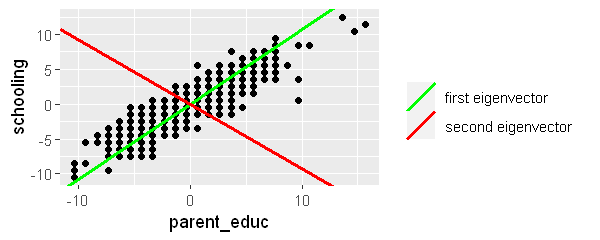

In [39]:
options(repr.plot.width=5, repr.plot.height=2) #adjust plots
plot_2D

average eigenvectors make no sense -> just increase sample size. Convergence in Probability?

In [17]:
set.seed(20)
sample_size_2D <- c(20, 100, 500, 2000, 5000, 8000) #determine number of each sample size
plots_2D <- lapply(sample_size_2D, plot_2D_data, true_phi = phi_2D, true_X = X_2D, legend = TRUE, transform = trans)
legend <- cowplot::get_legend(plots_2D[[1]] + theme(legend.position = "bottom")) #cowplot::otherwise cowplot's ggplot theme is loaded
p_grid <- cowplot::plot_grid(plotlist = plots_2D, ncol = 3)

**Table X.X - Convergence of the Direction of Eigenvectors of Years of Parent's Education and Years of Schooling by Increasing the Sample Size**

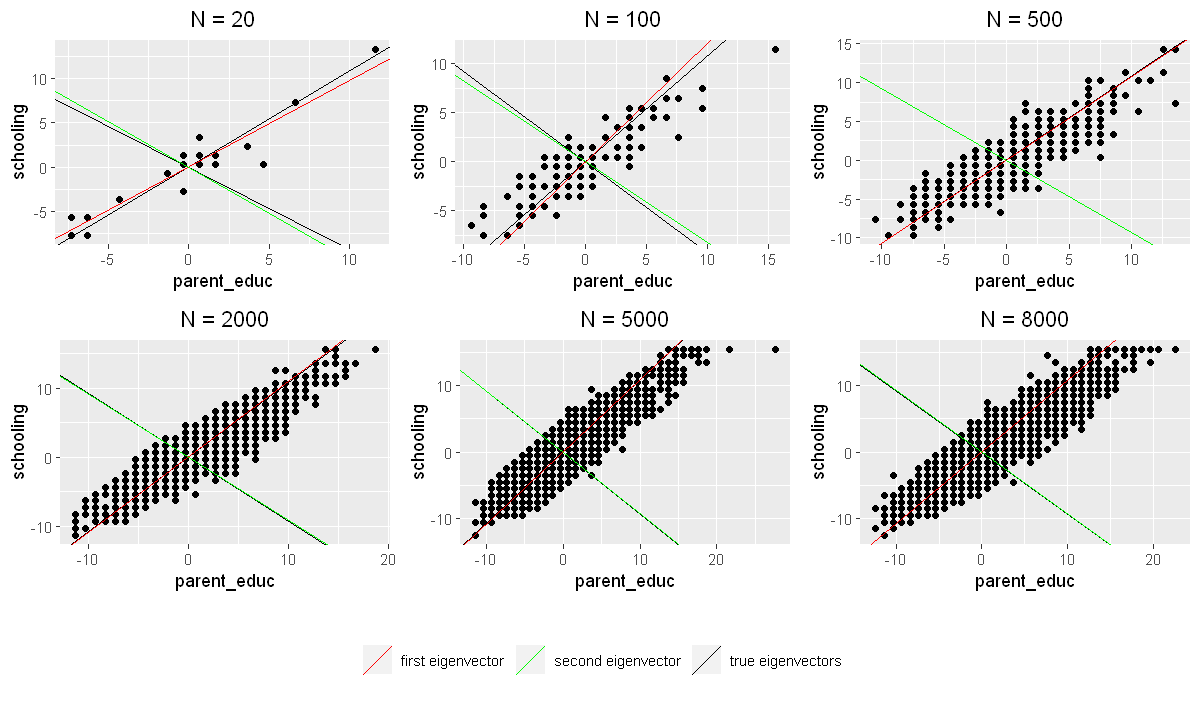

In [38]:
options(repr.plot.width=10, repr.plot.height=6) #adjust plots
cowplot::plot_grid(p_grid, legend, ncol = 1, rel_heights = c(1, 0.2))

## 4.4 Variance of the PCR Coefficients $\hat{\beta}$ in a Simulation Study

The question on how to compute the variance of the estimator arises. I will show two possibilities to compute the variance of the case using the $[\phi]$ class and the case using the estimated class of phi $[\hat{\phi}]$. If the notation $\hat{\beta}$ is used in this section, this indicates that the given statement holds for for $\hat{\beta_s}$ and $\hat{\beta_t}$. 


**Table X.X - Possibilities to Compute the Variance of $\beta$ and their Issues with non-uniquness of the Eigenvectors**


|      |   $[\phi]$   |   $[\hat{\phi}]$   |
|------|------|------|
|empirical distribution| no issue of uniquness  | $\hat{\pmb \phi}$ is not unique which increases the variance    |
|formula *(3.16)*/*(3.21)*|  $\pmb \phi$ is not unique but this does not cause problems since always the same $\pmb \phi$ is used |   no issue of uniquness since eigenvalues are unique   |



In [61]:
set.seed(12345)
M <- 8 # do it for all since it does not change the other
population_Y <- cbind(population$logwage, X)
sample_size <- seq(200, 10000, by = 200)

numb_it <- 400
#variance_analysis_results_cl <- lapply(sample_size, coef_var_analysis_cl, population = population_Y, true_phi = phi, M = M,
#                                       transform = trans, iterations = numb_it, print_it = TRUE)
#load data since its huge
load("SimData/variance_analysis_results_cl.Rda")

variance_plots_data <-  prepare_variance_plots(list_coef_var_analysis = variance_analysis_results_cl, sample_size = sample_size, confidence = 0.99)
xlab <- 'Sample Size'
ylab <- 'Variance Estimator'
numb_columns <- 3
col_prac_formula <- 'orange'
col_prac <- 'blue'
col_theo_formula <- 'green'
col_theo <- 'red'

What I do:
1. Difference between prac and prac with formula. would expect that prac is higehr due to problem of non-uniqueness of phi hat
2. Difference between theo and theo formula. would expect no difference since phi is chosen a priori
with one and two i have established that i can compare prac formula and theo formula
3. difference between prac formula and theo formula. what I wanted to look at.
4. show (for completeness how variance of Y changes)

explain everything briefly. with the formulas from section 3

**Table X.X - Variance of $\hat{\beta_s}$ (Stochastic Phi) Computed with Formula 3.23 vs. Variance of $\hat{\beta_s}$ (Stochastic Phi) Computed with Formula 3.24**  

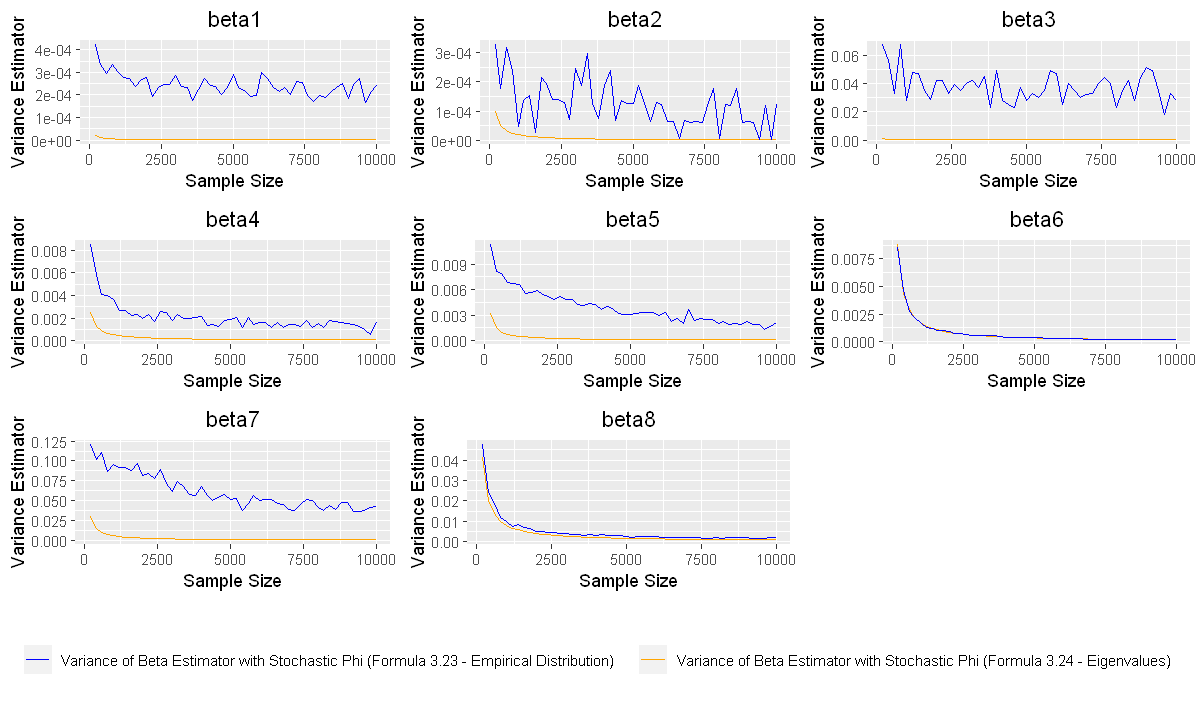

In [62]:
options(repr.plot.width=10, repr.plot.height=6) #adjust plots
plots_variance(df_1 = variance_plots_data$means_cl_prac_formula, legend_df1 = 'Variance of Beta Estimator with Stochastic Phi (Formula 3.24 - Eigenvalues)', colour_1 = col_prac_formula,
               df_2 = variance_plots_data$means_cl_prac, legend_df2 = 'Variance of Beta Estimator with Stochastic Phi (Formula 3.23 - Empirical Distribution)', colour_2 = col_prac,
               sample_size = sample_size, xlab_string = xlab, ylab_string = ylab, numb_columns = numb_columns, numb_plots = NULL)

**Table X.X - Variance of $\hat{\beta_t}$ (True Phi) Computed with Formula 3.23 vs. Variance of $\hat{\beta_t}$ (True Phi) Computed with Formula 3.25**  

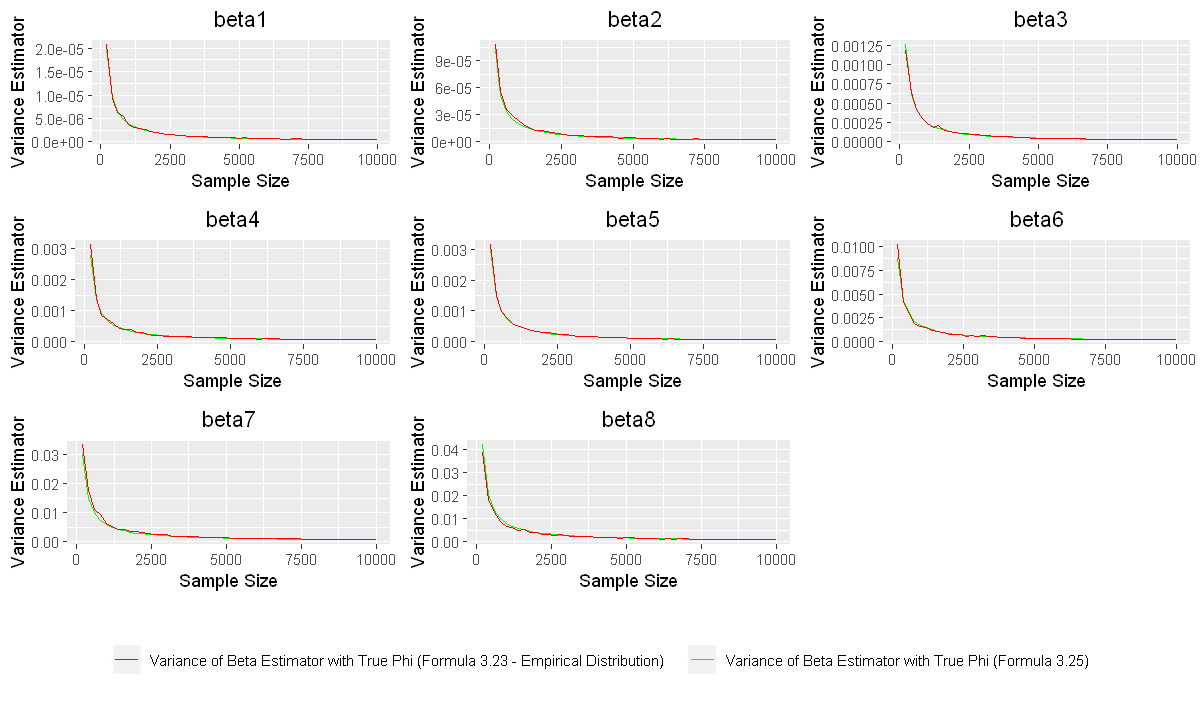

In [63]:
plots_variance(df_1 = variance_plots_data$means_cl_theo_formula, legend_df1 = 'Variance of Beta Estimator with True Phi (Formula 3.25)', colour_1 = col_theo_formula,
               df_2 = variance_plots_data$means_cl_theo, legend_df2 = 'Variance of Beta Estimator with True Phi (Formula 3.23 - Empirical Distribution)', colour_2 = col_theo,
               sample_size = sample_size, xlab_string = xlab, ylab_string = ylab, numb_columns = numb_columns, numb_plots = NULL)

**Table X.X - Variance of $\hat{\beta_t}$ (True Phi) Computed with Formula 3.25 vs. Variance of $\hat{\beta_s}$ (Stochastic Phi) Computed with Formula 3.24**  

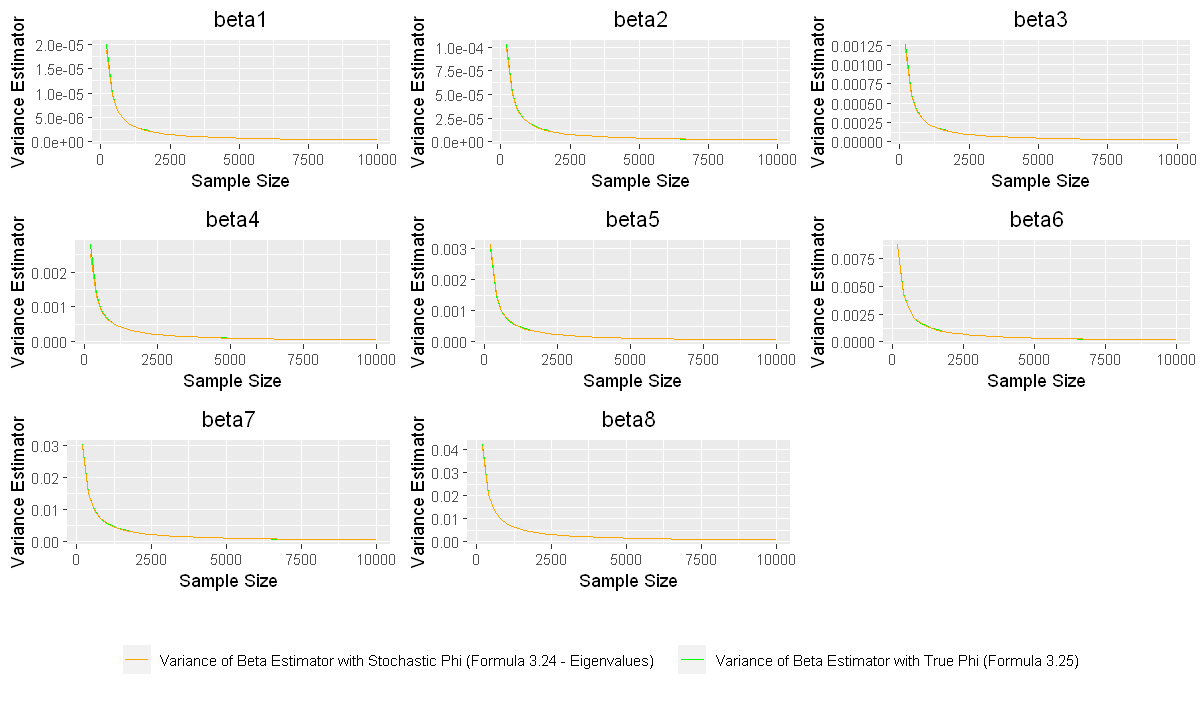

In [64]:
plots_variance(df_1 = variance_plots_data$means_cl_theo_formula, legend_df1 = 'Variance of Beta Estimator with True Phi (Formula 3.25)', colour_1 = col_theo_formula,
               df_2 = variance_plots_data$means_cl_prac_formula, legend_df2 = 'Variance of Beta Estimator with Stochastic Phi (Formula 3.24 - Eigenvalues)', colour_2 = col_prac_formula,
               sample_size = sample_size, xlab_string = xlab, ylab_string = ylab, numb_columns = numb_columns, numb_plots = NULL)

say that prac vs theo does not make sense, since prac has issue with choice of phi

In [100]:
sample_size <- seq(200, 5000, by = 200)
#set.seed(12345)
#population_Y <- cbind(population$logwage, X)
#M <- 8 # do it for all since it does not change the other
#sample_size <- seq(200, 5000, 200)
numb_it <- 400
#variance_analysis_results <- lapply(sample_size, coef_var_analysis, population = population_Y, true_phi = phi, M = M, transform = trans, iterations = numb_it, numb_iterations = 400)

load("SimData/variance_analysis_results.Rda")
confidence <- 0.99
variance_plots_data_CI <- lapply(c(1:(length(variance_analysis_results[[1]]))), prepare_variances_plots_CI, list_variances = variance_analysis_results,
                                            sample_size = sample_size, confidence = confidence, type_CI = 'mean', numb_it = numb_it)

xlab <- 'Sample Size'
ylab <- 'Mean of Variance Estimate'
numb_columns <- 3
col_prac_formula <- 'orange'
col_prac <- 'blue'
col_theo_formula <- 'green'
col_theo <- 'red'
xlab_string <- xlab
ylab_string <- ylab

**Table X.X - Variance of $\hat{\beta_s}$ (Stochastic Phi) Computed with Formula 3.23 vs. Variance of $\hat{\beta_s}$ (Stochastic Phi) Computed with Formula 3.24**  

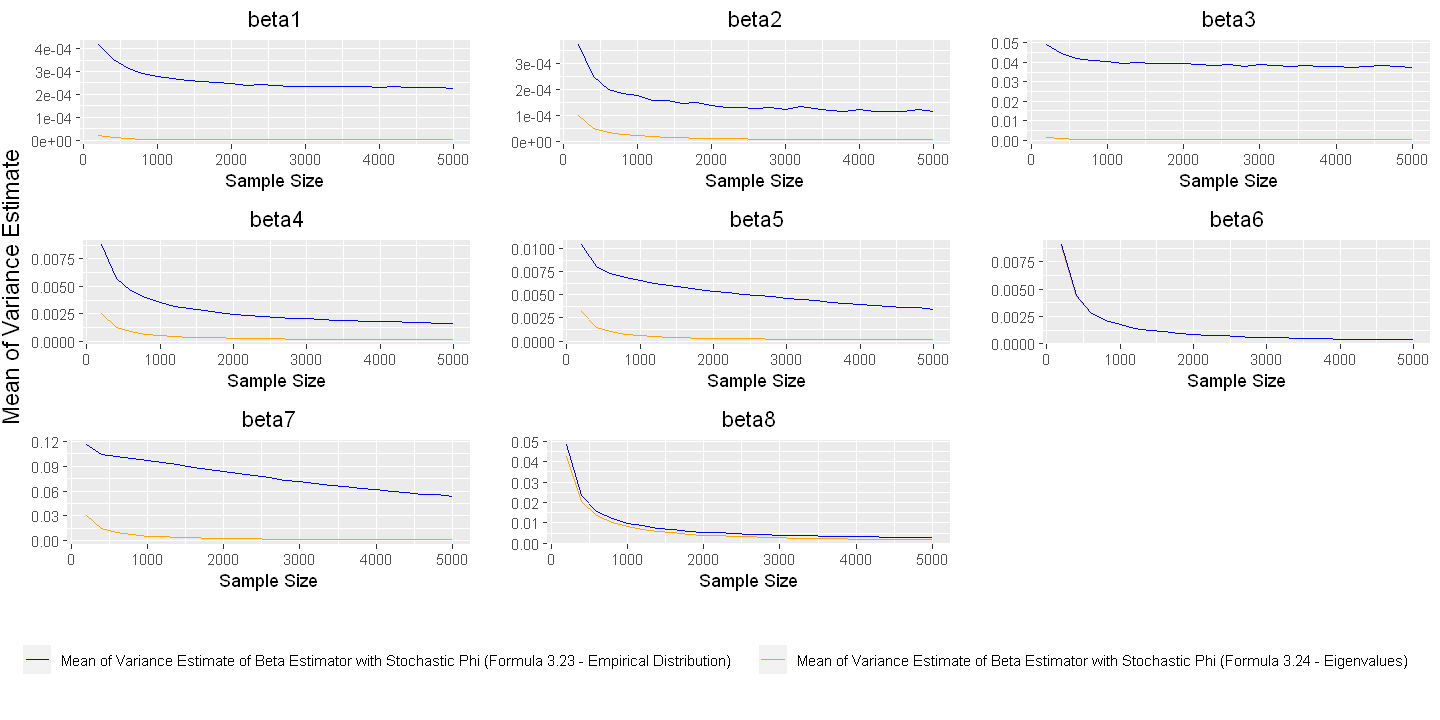

In [94]:
options(repr.plot.width=12, repr.plot.height=6) #adjust plots
plots_variance_CI(variance_plots_data = variance_plots_data_CI, first_method = 'beta_prac_formula', second_method = 'beta_prac',
                  colour_1 = col_prac_formula, colour_2 = col_prac, xlab_string = xlab, ylab_string = ylab,
                  legend_df1 = 'Mean of Variance Estimate of Beta Estimator with Stochastic Phi (Formula 3.24 - Eigenvalues)',
                  legend_df2 = 'Mean of Variance Estimate of Beta Estimator with Stochastic Phi (Formula 3.23 - Empirical Distribution)',
                  numb_columns = numb_columns, sample_size = sample_size, subtitle = 'beta')

**Table X.X - Variance of $\hat{\beta_t}$ (True Phi) Computed with Formula 3.23 vs. Variance of $\hat{\beta_t}$ (True Phi) Computed with Formula 3.25**  

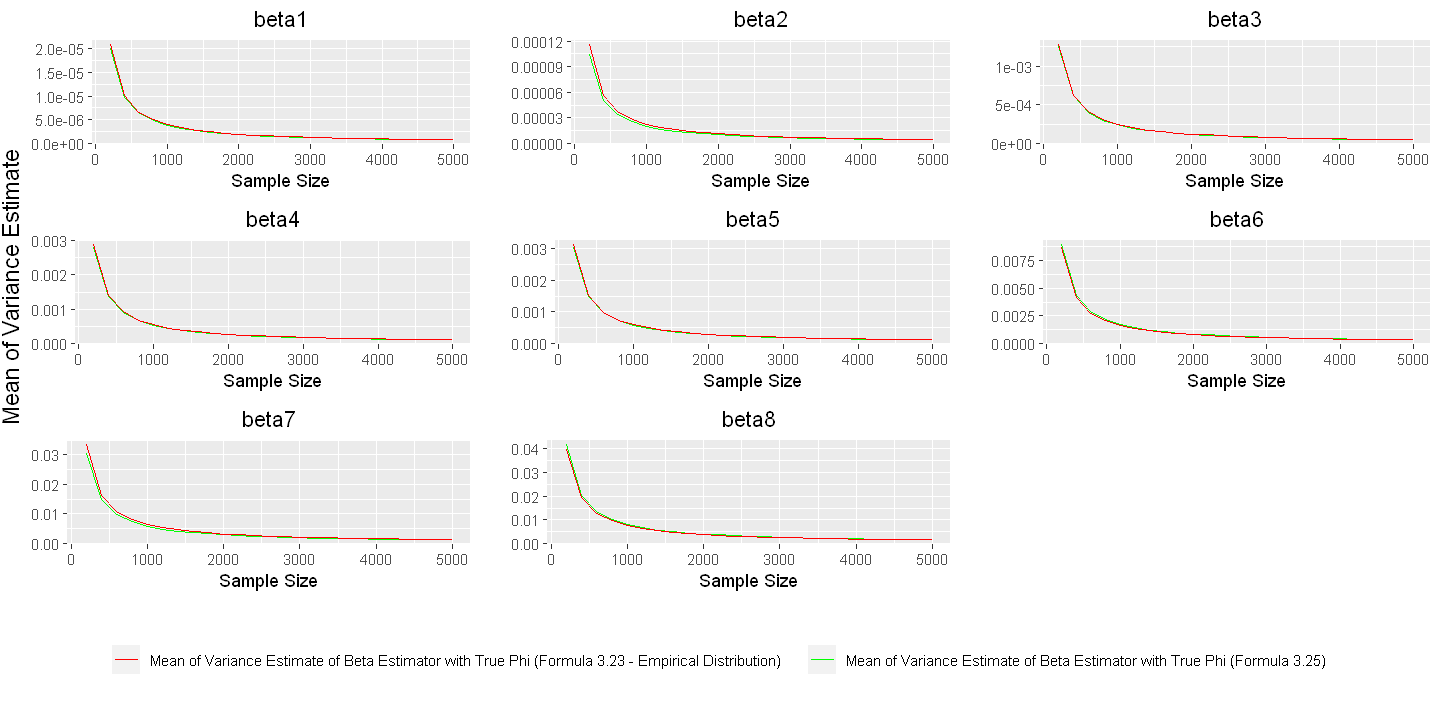

In [95]:
plots_variance_CI(variance_plots_data = variance_plots_data_CI, first_method = 'beta_theo_formula', second_method = 'beta_theo',
                  colour_1 = col_theo_formula, colour_2 = col_theo, xlab_string = xlab, ylab_string = ylab,
                  legend_df1 = 'Mean of Variance Estimate of Beta Estimator with True Phi (Formula 3.25)',
                  legend_df2 = 'Mean of Variance Estimate of Beta Estimator with True Phi (Formula 3.23 - Empirical Distribution)',
                  numb_columns = numb_columns, sample_size = sample_size, subtitle = 'beta')

**Table X.X - Variance of $\hat{\beta_t}$ (True Phi) Computed with Formula 3.25 vs. Variance of $\hat{\beta_s}$ (Stochastic Phi) Computed with Formula 3.24**  

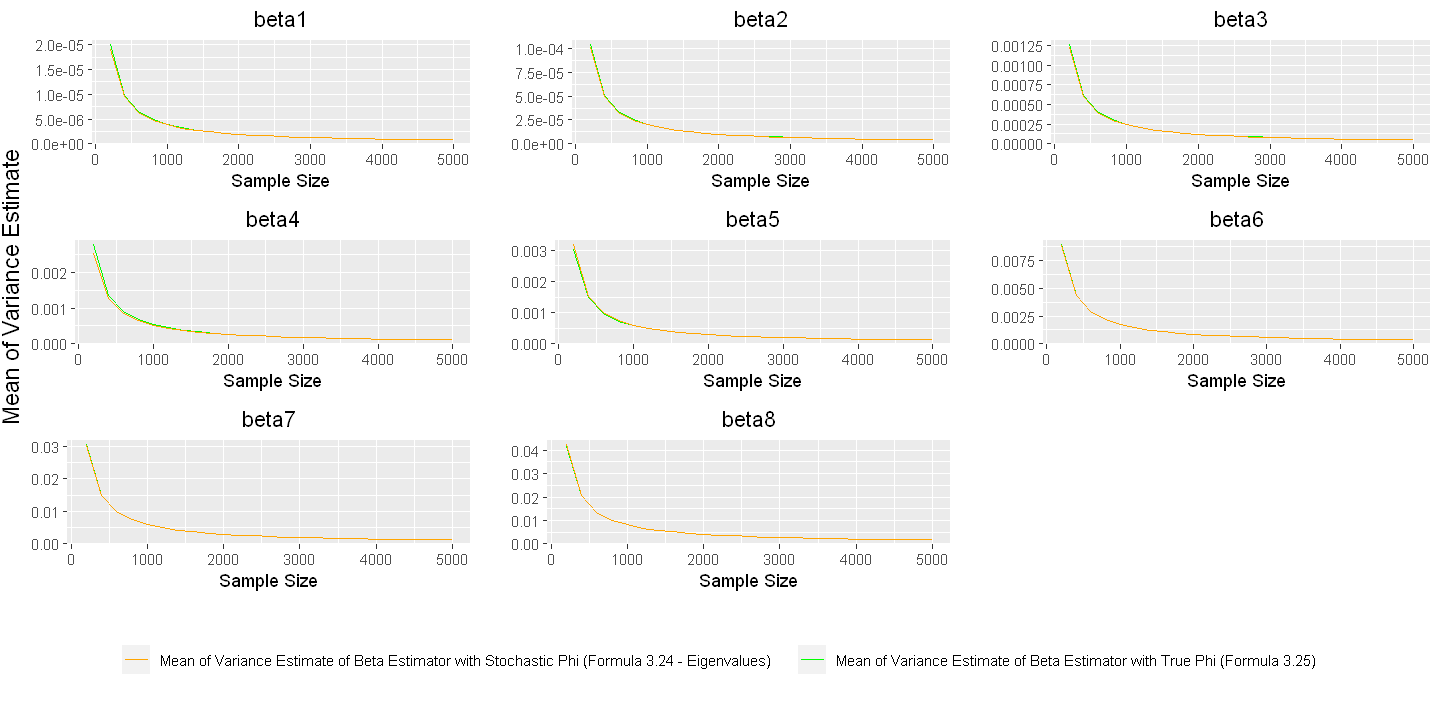

In [96]:
plots_variance_CI(variance_plots_data = variance_plots_data_CI, first_method = 'beta_theo_formula', second_method = 'beta_prac_formula',
                  colour_1 = col_theo_formula, colour_2 = col_prac_formula, xlab_string = xlab, ylab_string = ylab,
                  legend_df1 = 'Mean of Variance Estimate of Beta Estimator with True Phi (Formula 3.25)',
                  legend_df2 = 'Mean of Variance Estimate of Beta Estimator with Stochastic Phi (Formula 3.24 - Eigenvalues)',
                  numb_columns = numb_columns, sample_size = sample_size, subtitle = 'beta')

put one with 99 percent coverage in appendix

## 4.5 Variance of $\hat{Y}$

In [101]:
variances_Y_prac <- prepare_Y_variances(meth_interest = 'variances_Y_prac', list_variances = variance_analysis_results, confidence = confidence)
variances_Y_theo <- prepare_Y_variances(meth_interest = 'variances_Y_theo', list_variances = variance_analysis_results, confidence = confidence)
list_var_Y <- list(list('prac' = variances_Y_prac, 'theo' = variances_Y_theo))

**Table X.X - Variance of $\hat{Y}_t$ (True Phi) vs. Variance of $\hat{Y}_s$ (Stochastic Phi)**  

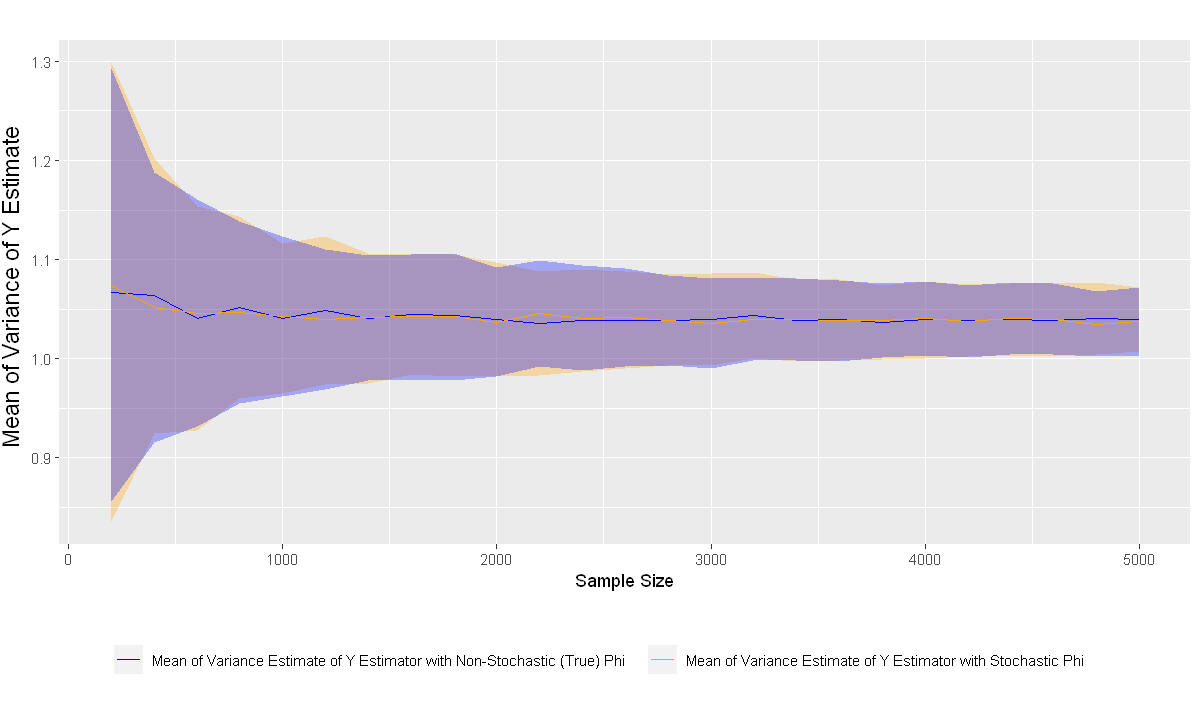

In [106]:
options(repr.plot.width=10, repr.plot.height=6) #adjust plots
plots_variance_CI(variance_plots_data = list_var_Y, first_method = 'theo', second_method = 'prac',
                  colour_1 = 'orange', colour_2 = 'blue', xlab_string = 'Sample Size', ylab_string = 'Mean of Variance of Y Estimate',
                  legend_df1 = 'Mean of Variance Estimate of Y Estimator with Non-Stochastic (True) Phi',
                  legend_df2 = 'Mean of Variance Estimate of Y Estimator with Stochastic Phi',
                  numb_columns = 1, sample_size = sample_size, subtitle = 'Y', make_subtitle = FALSE)